In [1]:
import matplotlib
%matplotlib inline
import os
import astropy
import sourcefinder
import logging
import pandas as pd
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
import numpy as np
import time
import seaborn as sns


/home/gijs/Work/trap-ng/.virtualenv/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# settings
datadir = "../data/"
de_ruiter = Angle(1 * u.deg)

In [3]:
sns.set(rc={"figure.figsize": (16, 6)})

In [4]:
datafiles = [datadir + i for i in sorted(j for j in os.listdir(datadir) if j.endswith(".fits"))]

In [5]:
# we can move this to a helper script
from sourcefinder.accessors import open as open_accessor
from sourcefinder.accessors import sourcefinder_image_from_accessor

def extract_sources(path, margin=10, extraction_radius_pix=400, back_size_x=32, back_size_y=32,
                    residuals=True, detection_threshold=5, analysis_threshold=3,
                    deblend_nthresh=0, force_beam=True):

    accessor = open_accessor(path, plane=0)
    obstime = accessor.taustart_ts
    data_image = sourcefinder_image_from_accessor(accessor,
                    margin=margin,
                    radius=extraction_radius_pix,
                    back_size_x=back_size_x,
                    back_size_y=back_size_y)

    return obstime, data_image.extract(
        det=detection_threshold,
        anl=analysis_threshold,
        deblend_nthresh=deblend_nthresh,
        force_beam=force_beam
)


In [6]:
# initialise catalog and lightcurves with one image
obstime, sources = extract_sources(datafiles[0])
ra, dec = zip(*[(i.ra.value, i.dec.value) for i in sources])
catalog = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
lightcurves = pd.DataFrame(data=[[i.flux.value for i in sources]], index=[obstime])

No handlers could be found for logger "sourcefinder.accessors.fitsimage"
/home/gijs/Work/pyse/sourcefinder/image.py:761: RuntimeWarning: invalid value encountered in greater
  (self.data_bgsubbed > analysisthresholdmap) &


In [7]:
for datafile in datafiles[1:]:
    start = time.time()
    obstime, new_sources = extract_sources(datafile)
    ra, dec = zip(*[(i.ra.value, i.dec.value) for i in new_sources])
    astro_sources = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    idx, sep2d, dist3d = astropy.coordinates.match_coordinates_sky(astro_sources, catalog)

    # new sources!
    too_far = sep2d > de_ruiter

    # first add the new sources and fluxes
    catalog = SkyCoord([catalog, astro_sources[too_far]])
    all_fluxes = np.array([i.flux.value for i in new_sources])
    new_fluxes = all_fluxes[too_far]

    # insert NaN values for previous timestamp but new sources
    empty_lighcurve = [np.nan] * len(lightcurves.index)
    c = len(lightcurves.columns)
    new_data = {i: empty_lighcurve for i in range(c, c+sum(too_far))}
    t = pd.DataFrame(data=new_data, index=lightcurves.index)
    lightcurves_with_new_sources = pd.concat([lightcurves, t], axis=1)

    # then check if we don't have any many-to-one associations (2 new measurements matching the same source)
    next_flux_index = idx[~too_far]
    if (Counter(next_flux_index) - Counter(set(next_flux_index))).keys():
        raise Exception("many-to-one")

    measures = np.array([np.nan] * len(lightcurves.columns))
    measures[next_flux_index] = all_fluxes[~too_far]
    lightcurves_with_new_sources.loc[obstime] = pd.Series(np.concatenate([measures, all_fluxes[too_far]]))
    lightcurves = lightcurves_with_new_sources
    end = time.time()
    print (datafile, end-start)


('../data/20160831151015UTC_S307.5_I16x1_W6_A1.5.fits', 1.1596179008483887)
('../data/20160831151016UTC_S307.5_I16x1_W6_A1.5.fits', 1.172360897064209)
('../data/20160831151017UTC_S307.5_I16x1_W6_A1.5.fits', 1.1705288887023926)
('../data/20160831151018UTC_S307.5_I16x1_W6_A1.5.fits', 1.1658639907836914)
('../data/20160831151019UTC_S307.5_I16x1_W6_A1.5.fits', 1.1811718940734863)
('../data/20160831151020UTC_S307.5_I16x1_W6_A1.5.fits', 1.143653154373169)
('../data/20160831151021UTC_S307.5_I16x1_W6_A1.5.fits', 1.1651058197021484)
('../data/20160831151022UTC_S307.5_I16x1_W6_A1.5.fits', 1.1907949447631836)
('../data/20160831151023UTC_S307.5_I16x1_W6_A1.5.fits', 1.1052510738372803)
('../data/20160831151024UTC_S307.5_I16x1_W6_A1.5.fits', 1.1625308990478516)
('../data/20160831151025UTC_S307.5_I16x1_W6_A1.5.fits', 1.1460418701171875)
('../data/20160831151026UTC_S307.5_I16x1_W6_A1.5.fits', 1.1309819221496582)
('../data/20160831151027UTC_S307.5_I16x1_W6_A1.5.fits', 1.1226770877838135)
('../data/2016

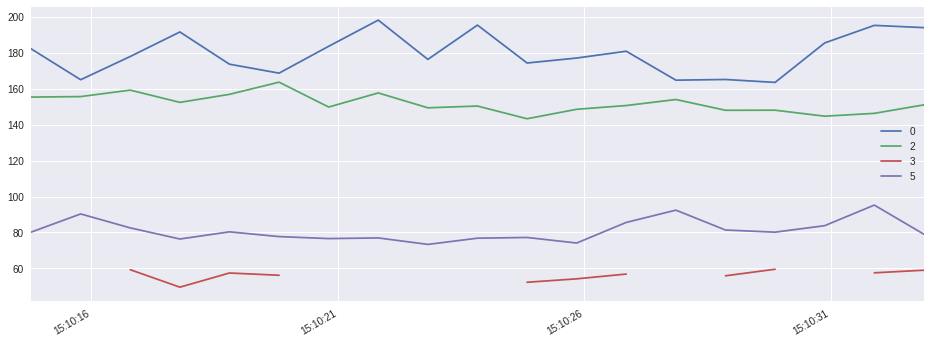

In [8]:
_ = lightcurves[[0, 2, 3, 5]].plot()